<a href="https://colab.research.google.com/github/nooh1318/fire/blob/main/fireweek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/the-wildfire-dataset
⚠️ GPU is Unavailable!
Number of Classes: 2
Classes: ['nofire', 'fire']
Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.


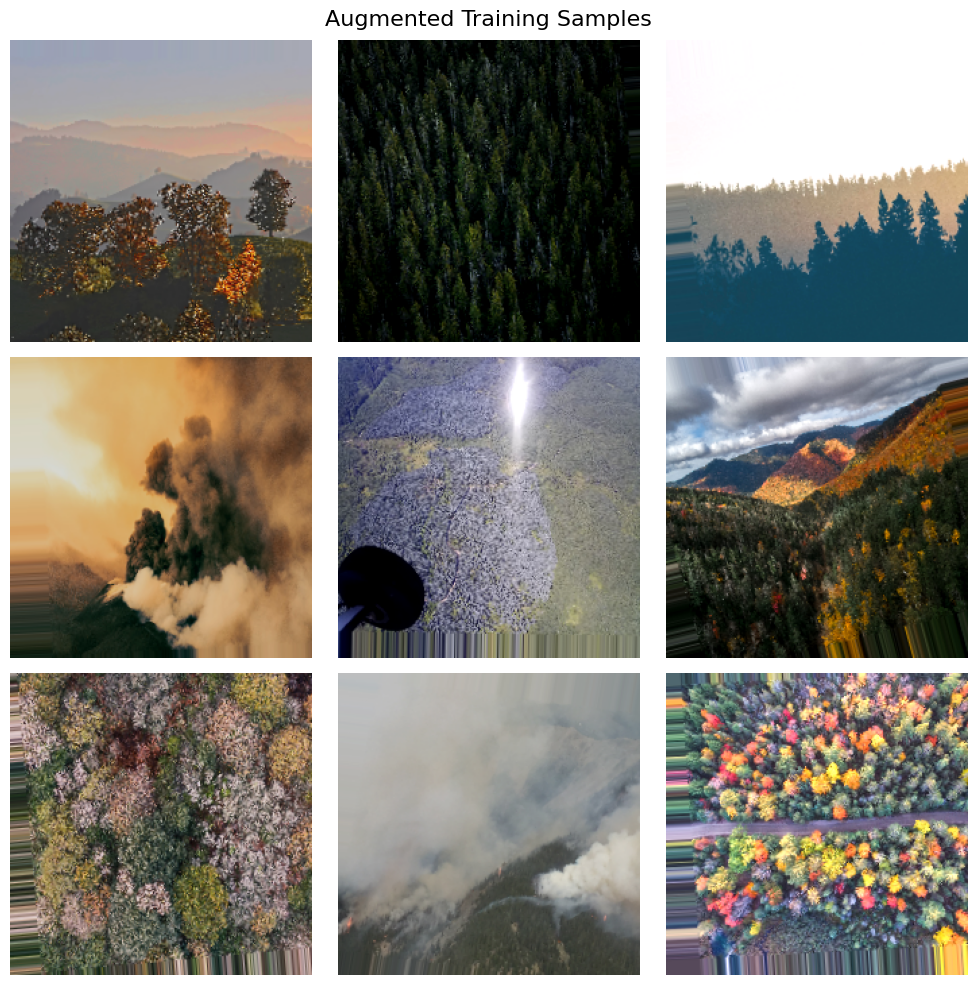

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
10/59 ━━━━━━━━━━━━━━━━━━━━ 8:36 11s/step - accuracy: 0.5324 - loss: 10.9256

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


52/59 ━━━━━━━━━━━━━━━━━━━━ 1:12 10s/step - accuracy: 0.5511 - loss: 6.4361

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 773s 13s/step - accuracy: 0.5552 - loss: 5.9646 - val_accuracy: 0.6119 - val_loss: 0.6894
Epoch 2/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 776s 12s/step - accuracy: 0.6124 - loss: 0.6937 - val_accuracy: 0.6119 - val_loss: 0.6832
Epoch 3/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 744s 12s/step - accuracy: 0.6199 - loss: 0.6809 - val_accuracy: 0.6119 - val_loss: 0.6781
Epoch 4/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 743s 13s/step - accuracy: 0.6070 - loss: 0.6778 - val_accuracy: 0.6119 - val_loss: 0.6743
Epoch 5/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 704s 12s/step - accuracy: 0.6205 - loss: 0.6718 - val_accuracy: 0.6119 - val_loss: 0.6721
Epoch 6/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 758s 12s/step - accuracy: 0.6226 - loss: 0.6688 - val_accuracy: 0.6119 - val_loss: 0.6705
Epoch 7/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 716s 12s/step - accuracy: 0.6031 - loss: 0.6730 - val_accuracy: 0.6119 - val_loss: 0.6694


✅ Model saved as 'wildfire_model.h5'


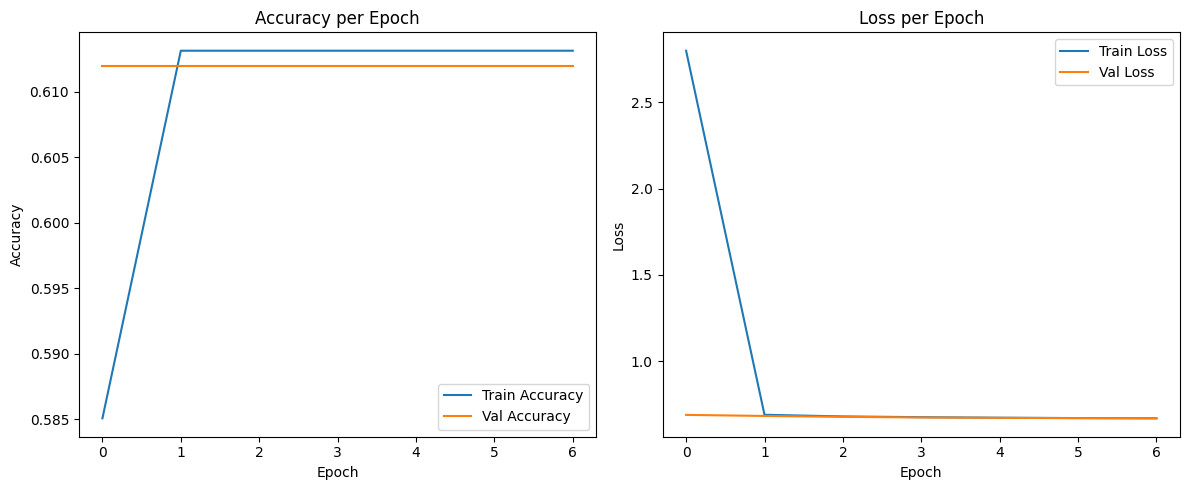

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# ✅ Step 1: Download dataset
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")
print("Path to dataset files:", path)

# ✅ Step 2: GPU check
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('✅ GPU is Available!')
else:
    print('⚠️ GPU is Unavailable!')

# ✅ Step 3: Paths
train_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/train')
val_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/val')
test_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/test')

# ✅ Step 4: Class info
classes = os.listdir(train_dir)
num_classes = len(classes)
print(f'Number of Classes: {num_classes}\nClasses: {classes}')

# ✅ Step 5: Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ✅ Step 6: Visualize some augmented training images
augmented_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()

# ✅ Step 7: Load EfficientNetB0 and freeze it
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ✅ Step 8: Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ✅ Step 9: Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Step 10: Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=7
)

# ✅ Step 11: Save the model
model.save("wildfire_model.h5")
print("✅ Model saved as 'wildfire_model.h5'")

# ✅ Step 12: Show training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()





In [8]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model("wildfire_model.h5")
print("✅ Model loaded successfully!")

# Prepare an image for prediction
img_path = "test3.jpg"  # 🔁 Replace with your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize like in training

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
print(f"🔥 Predicted Class Index: {predicted_class}")


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🔥 Predicted Class Index: 1
